In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the libraries and intializing the path variables

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import shutil
from glob import glob
from PIL import Image

In [56]:
data_path = '/content/drive/MyDrive/waste_segregation/v002/dataset-resized/'
folder_path = '/content/drive/MyDrive/waste_segregation/v002/'
save_model_path = '/content/drive/MyDrive/waste_segregation/v002/saved_models/'
visualisation_path = '/content/drive/MyDrive/waste_segregation/v002/visualisations/'

In [57]:
if not os.path.exists(save_model_path):  # Creating the directory if it does not exist
    os.makedirs(save_model_path)

if not os.path.exists(visualisation_path):  # Creating the directory if it does not exist
    os.makedirs(visualisation_path)

In [58]:
# Constants

IMAGE_DIMS = (224, 224)
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 32
MODEL_EPOCHS = 40

# Unzipping Dataset

- Dataset Github: https://github.com/garythung/trashnet
- Dataset GDrive link: https://drive.google.com/drive/folders/0B3P9oO5A3RvSUW9qTG11Ul83TEE?resourcekey=0-F-D8v2tnSfByG6ll3t9JxA

In [59]:
if not os.path.exists(data_path):  # unzipping only if it is not already unzipped
    shutil.unpack_archive(folder_path + "dataset-resized.zip", folder_path)

In [60]:
glob(data_path + '*/')

['/content/drive/MyDrive/waste_segregation/v002/dataset-resized/cardboard/',
 '/content/drive/MyDrive/waste_segregation/v002/dataset-resized/glass/',
 '/content/drive/MyDrive/waste_segregation/v002/dataset-resized/metal/',
 '/content/drive/MyDrive/waste_segregation/v002/dataset-resized/paper/',
 '/content/drive/MyDrive/waste_segregation/v002/dataset-resized/plastic/',
 '/content/drive/MyDrive/waste_segregation/v002/dataset-resized/trash/']

In [61]:
# code for getting all files in a directory
# inspired from https://theprogrammingexpert.com/count-number-of-files-in-directory-python/

def count_number_of_files(path):
    print("Main Directory:", path)
    print("Files in Main Directory:", len(os.listdir(path)))
    print("\nSub-Directories:")
    for root, dirs, files in os.walk(path):
        for name in dirs:
            print(os.path.join(root,name), ":", len(os.listdir(os.path.join(root,name))))
            # print()
            # print(files)

count_number_of_files(data_path)

Main Directory: /content/drive/MyDrive/waste_segregation/v002/dataset-resized/
Files in Main Directory: 7

Sub-Directories:
/content/drive/MyDrive/waste_segregation/v002/dataset-resized/cardboard : 403
/content/drive/MyDrive/waste_segregation/v002/dataset-resized/glass : 501
/content/drive/MyDrive/waste_segregation/v002/dataset-resized/metal : 410
/content/drive/MyDrive/waste_segregation/v002/dataset-resized/paper : 594
/content/drive/MyDrive/waste_segregation/v002/dataset-resized/plastic : 482
/content/drive/MyDrive/waste_segregation/v002/dataset-resized/trash : 137


In [62]:
dataset_classes = {'paper' : 594,
                   'metal' : 410,
                   'cardboard' : 403,
                   'trash' : 137,
                   'glass' : 501,
                   'plastic' : 482}
df_dataset_classes = pd.DataFrame(dataset_classes.items(), columns=['Category', 'No_of_Images'])
df_dataset_classes = df_dataset_classes.sort_values(by='No_of_Images', ascending=False)
df_dataset_classes.reset_index(drop=True, inplace=True)
df_dataset_classes.head()

,Category,No_of_Images
0,paper,594
1,glass,501
2,plastic,482
3,metal,410
4,cardboard,403


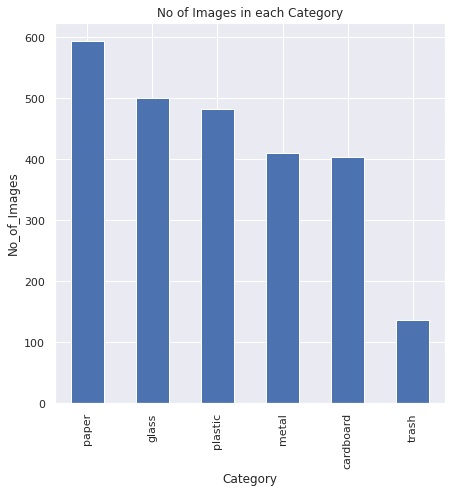

In [63]:
df_dataset_classes.plot.bar(x = 'Category',
                            y = 'No_of_Images',
                            xlabel = 'Category', 
                            ylabel = 'No_of_Images', 
                            legend = False,
                            figsize=(7,7))
plt.title('No of Images in each Category')

plt.savefig(os.path.join(visualisation_path, 'class_distribution.png'), 
            dpi=300, bbox_inches='tight')

In [64]:
total_images = df_dataset_classes['No_of_Images'].sum()
total_images

2527

In [65]:
# adding a column to the dataframe for the percentage of images in each category
df_dataset_classes['Percentage'] = df_dataset_classes['No_of_Images'] / total_images * 100
df_dataset_classes

,Category,No_of_Images,Percentage
0,paper,594,23.506134
1,glass,501,19.825880
2,plastic,482,19.074001
3,metal,410,16.224772
4,cardboard,403,15.947764
5,trash,137,5.421448


# Converting images to Numpy.NDArray

In [ ]:
def extract_image_array(filename, required_size=IMAGE_DIMS):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# resize pixels to the model size
	image = image.resize(required_size)
	image_array = np.asarray(image)
	return image_array

In [ ]:
def load_images(directory):
  images = []
  for filename in os.listdir(directory):
    # path
    path = directory + filename
    # get image
    image = extract_image_array(path)
    # store
    images.append(image)
  return images

In [ ]:
def load_dataset(directory):
  X, y = [], []
  # enumerate folders, on per class
  for subdir in os.listdir(directory):
    # path
    path = directory + subdir + '/'
    # skip any files that might be in the dir
    if not os.path.isdir(path):
      continue
    # load all images in the subdirectory
    images = load_images(path)
    # create labels
    labels = [subdir for _ in range(len(images))]
    # summarize progress
    print('>loaded %d examples for class: %s' % (len(images), subdir))
    # store
    X.extend(images)
    y.extend(labels)
    del images
    del labels
  return np.asarray(X), np.asarray(y)

In [ ]:
# load dataset
data, labels = load_dataset(data_path)
print(data.shape, labels.shape)
np.savez_compressed(folder_path + 'v002_dataset.npz', data, labels)

>loaded 403 examples for class: cardboard
>loaded 501 examples for class: glass
>loaded 410 examples for class: metal
>loaded 594 examples for class: paper
>loaded 482 examples for class: plastic
>loaded 137 examples for class: trash
(2527, 224, 224, 3) (2527,)


# Pre-processing for models

In [66]:
# load the dataset

dataset = np.load(folder_path + 'v002_dataset.npz')
data, char_labels = dataset['arr_0'], dataset['arr_1']

In [67]:
print(data.shape)
print(char_labels.shape)

(2527, 224, 224, 3)
(2527,)


# Data transformation for models

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# Splitting numpy array of all images into train, test and validation sets

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    char_labels, 
                                                    test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=test_ratio/(test_ratio + validation_ratio)) 

print("Training set:", 
      "\nX_train: ", X_train.shape, ";", len(X_train)*100/len(data),
      "\ny_train: ", y_train.shape, ";", len(y_train)*100/len(char_labels))

print("\nValidation set:", 
      "\nX_val: ", X_val.shape, ";", len(X_val)*100/len(data),
      "\ny_val: ", y_val.shape, ";", len(y_val)*100/len(char_labels))

print("\nTesting set:", 
      "\nX_test: ", X_test.shape, ";", len(X_test)*100/len(data),
      "\ny_test: ", y_test.shape, ";", len(y_test)*100/len(char_labels))

Training set: 
X_train:  (1895, 224, 224, 3) ; 74.99010684606253 
y_train:  (1895,) ; 74.99010684606253

Validation set: 
X_val:  (379, 224, 224, 3) ; 14.998021369212506 
y_val:  (379,) ; 14.998021369212506

Testing set: 
X_test:  (253, 224, 224, 3) ; 10.01187178472497 
y_test:  (253,) ; 10.01187178472497


In [70]:
X_test

array([[[[218, 220, 233],
         [217, 219, 232],
         [216, 218, 231],
         ...,
         [153, 154, 159],
         [152, 153, 158],
         [151, 152, 157]],

        [[218, 220, 233],
         [217, 219, 232],
         [216, 218, 231],
         ...,
         [153, 154, 159],
         [152, 153, 158],
         [151, 152, 157]],

        [[218, 220, 233],
         [217, 219, 232],
         [216, 218, 231],
         ...,
         [153, 154, 159],
         [152, 153, 158],
         [151, 152, 157]],

        ...,

        [[219, 218, 232],
         [218, 217, 231],
         [217, 216, 230],
         ...,
         [133, 132, 137],
         [134, 133, 138],
         [134, 133, 138]],

        [[219, 218, 232],
         [218, 217, 231],
         [217, 216, 230],
         ...,
         [131, 130, 135],
         [132, 131, 136],
         [133, 132, 137]],

        [[219, 218, 232],
         [218, 217, 231],
         [217, 216, 230],
         ...,
         [130, 129, 134],
        

In [71]:
y_test

array(['plastic', 'plastic', 'metal', 'metal', 'plastic', 'plastic',
       'plastic', 'plastic', 'paper', 'glass', 'paper', 'metal', 'paper',
       'metal', 'metal', 'cardboard', 'paper', 'glass', 'plastic',
       'metal', 'metal', 'metal', 'trash', 'cardboard', 'cardboard',
       'cardboard', 'paper', 'metal', 'paper', 'trash', 'paper', 'glass',
       'glass', 'cardboard', 'metal', 'plastic', 'glass', 'paper',
       'paper', 'paper', 'metal', 'paper', 'paper', 'glass', 'paper',
       'metal', 'plastic', 'glass', 'paper', 'paper', 'paper', 'glass',
       'paper', 'cardboard', 'metal', 'glass', 'paper', 'glass',
       'cardboard', 'glass', 'glass', 'cardboard', 'paper', 'cardboard',
       'glass', 'glass', 'paper', 'plastic', 'glass', 'metal', 'plastic',
       'metal', 'paper', 'paper', 'cardboard', 'cardboard', 'paper',
       'paper', 'paper', 'paper', 'glass', 'plastic', 'paper',
       'cardboard', 'glass', 'metal', 'paper', 'plastic', 'metal',
       'paper', 'cardboard'

In [72]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [73]:
# prepare target labels for the model
def prepare_targets(input_char_labels):
  labelencoder = LabelEncoder()
  onehotencoder = OneHotEncoder()
  output_enc_labels = labelencoder.fit_transform(input_char_labels)
  output_enc_labels = onehotencoder.fit_transform(output_enc_labels.reshape(-1, 1)).toarray()
  return output_enc_labels, labelencoder, onehotencoder

In [74]:
y_train_enc, le_train, ohe_train = prepare_targets(y_train)
y_val_enc, le_val, ohe_val = prepare_targets(y_val)
y_test_enc, le_test, ohe_test = prepare_targets(y_test)

In [75]:
y_test_enc.shape

(253, 6)

In [76]:
y_test.shape

(253,)

In [77]:
print(y_test)

['plastic' 'plastic' 'metal' 'metal' 'plastic' 'plastic' 'plastic'
 'plastic' 'paper' 'glass' 'paper' 'metal' 'paper' 'metal' 'metal'
 'cardboard' 'paper' 'glass' 'plastic' 'metal' 'metal' 'metal' 'trash'
 'cardboard' 'cardboard' 'cardboard' 'paper' 'metal' 'paper' 'trash'
 'paper' 'glass' 'glass' 'cardboard' 'metal' 'plastic' 'glass' 'paper'
 'paper' 'paper' 'metal' 'paper' 'paper' 'glass' 'paper' 'metal' 'plastic'
 'glass' 'paper' 'paper' 'paper' 'glass' 'paper' 'cardboard' 'metal'
 'glass' 'paper' 'glass' 'cardboard' 'glass' 'glass' 'cardboard' 'paper'
 'cardboard' 'glass' 'glass' 'paper' 'plastic' 'glass' 'metal' 'plastic'
 'metal' 'paper' 'paper' 'cardboard' 'cardboard' 'paper' 'paper' 'paper'
 'paper' 'glass' 'plastic' 'paper' 'cardboard' 'glass' 'metal' 'paper'
 'plastic' 'metal' 'paper' 'cardboard' 'paper' 'paper' 'glass' 'glass'
 'plastic' 'plastic' 'paper' 'glass' 'glass' 'paper' 'paper' 'plastic'
 'metal' 'paper' 'plastic' 'cardboard' 'plastic' 'plastic' 'plastic'
 'plastic'

In [78]:
y_test_enc

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [79]:
y_test_enc[0]

array([0., 0., 0., 0., 1., 0.])

In [80]:
y_test_enc[1]

array([0., 0., 0., 0., 1., 0.])

# MODELS

In [81]:
# import the necessary packages
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import optimizers, Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam

In [82]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range = 20,
                         zoom_range = 0.15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         fill_mode = "nearest")

In [83]:
target_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Inception model

In [84]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [85]:
# load the InceptionV3 network
ibase_model = InceptionV3(weights = "imagenet", 
                         include_top = False,
                         input_tensor = Input(IMAGE_SIZE))

In [86]:
ibase_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [87]:
# construct the head of the model that will be placed on top of the
# the base model

ilast_layer = ibase_model.layers[-1]
print('last layer output shape: ', ilast_layer.output_shape)

ihead_model = ilast_layer.output
ihead_model = layers.Flatten()(ihead_model)
ihead_model = layers.Dense(6, activation = "softmax")(ihead_model) # For 6 classes

last layer output shape:  (None, 5, 5, 2048)


In [88]:
# place the head model on top of the base model
from tensorflow.keras.models import Model
ifinal_model = Model(inputs = ibase_model.input, outputs = ihead_model)

In [89]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in ibase_model.layers:
    layer.trainable = False

In [90]:
# compile our model
print("[INFO] compiling model...")

ifinal_model.compile(loss = "categorical_crossentropy", 
                    optimizer='adam',
                    metrics = ["accuracy"])

print("\n\n[INFO] model compilation complete!")

[INFO] compiling model...


[INFO] model compilation complete!


### Inception Model Checkpoint

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint
imodel_checkpoint_callback = ModelCheckpoint(filepath=os.path.join(save_model_path, 
                                                   "modelv002_IN01_{epoch:02d}.h5"), 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            monitor='val_loss',
                                            mode='min')

### Inception Model Learning Rate Reduction

In [92]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
ilearning_rate_reduction_callback = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                     patience = 2, 
                                                     verbose = 1, 
                                                     factor = 0.5, 
                                                     min_lr = 1e-6)

### Inception Model Early Stopping

In [93]:
from tensorflow.keras.callbacks import EarlyStopping
iearly_stopping_callback = EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=5)

### Model training

In [94]:
# train the head of the network
print("[INFO] model training - epochs and summary...\n\n")

ifinal_model_history = ifinal_model.fit(X_train, y_train_enc,
                                      steps_per_epoch = len(X_train) // BATCH_SIZE,
                                      validation_data = (X_val, y_val_enc),
                                      validation_steps = len(X_val) // BATCH_SIZE,
                                      epochs = MODEL_EPOCHS,
                                      callbacks = [imodel_checkpoint_callback, 
                                                   iearly_stopping_callback, 
                                                   ilearning_rate_reduction_callback])

print("\n\n[INFO] model training complete!\n\n")

[INFO] model training - epochs and summary...


Epoch 1/40
59/59 [==============================] - 14s 163ms/step - loss: 195.4397 - accuracy: 0.3320 - val_loss: 134.7457 - val_accuracy: 0.3773 - lr: 0.0010
Epoch 2/40
59/59 [==============================] - 8s 138ms/step - loss: 54.6563 - accuracy: 0.5156 - val_loss: 67.5487 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 3/40
59/59 [==============================] - 22s 375ms/step - loss: 33.3254 - accuracy: 0.5996 - val_loss: 66.4623 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 4/40
59/59 [==============================] - 19s 326ms/step - loss: 24.2722 - accuracy: 0.6712 - val_loss: 65.9941 - val_accuracy: 0.4274 - lr: 0.0010
Epoch 5/40
59/59 [==============================] - ETA: 0s - loss: 27.4686 - accuracy: 0.6706
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
59/59 [==============================] - 6s 99ms/step - loss: 27.4686 - accuracy: 0.6706 - val_loss: 69.0185 - val_accuracy: 0.4591 - lr: 0.0010
Epo

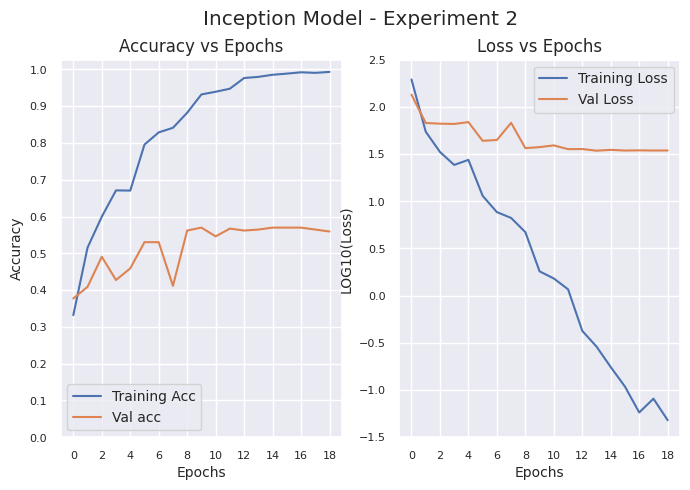

In [114]:
# Plots of Accuracy and Loss vs Epochs.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), dpi=100)


fig.suptitle("Inception Model - Experiment 2", fontdict = {'size': 10, 'weight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(ifinal_model_history.history['accuracy'], label='Training Acc')
ax[0].plot(ifinal_model_history.history['val_accuracy'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 19, 2))
ax[0].yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(np.log10(ifinal_model_history.history['loss']), label='Training Loss')
ax[1].plot(np.log10(ifinal_model_history.history['val_loss']), label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('LOG10(Loss)', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 19, 2))
ax[1].yaxis.set_ticks(np.arange(-1.5, 2.55, 0.5))

fig.savefig(os.path.join(visualisation_path, 
                         'v002_inception_IN01.png'), 
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [96]:
ifinal_model_history_df = pd.DataFrame(ifinal_model_history.history)
ifinal_model_history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,195.439682,0.331950,134.745697,0.377309,0.001000
1,54.656322,0.515560,67.548660,0.408971,0.001000
2,33.325417,0.599585,66.462265,0.490765,0.001000
3,24.272211,0.671162,65.994072,0.427441,0.001000
4,27.468567,0.670643,69.018539,0.459103,0.001000
5,11.409274,0.795643,43.728104,0.530343,0.000500
6,7.671909,0.828838,44.604984,0.530343,0.000500
7,6.654232,0.841286,67.831665,0.411610,0.000500
8,4.705379,0.882261,36.556248,0.562005,0.000250
9,1.807377,0.932054,37.490574,0.569921,0.000250


In [97]:
ifinal_model_history_df.to_csv(os.path.join(save_model_path, 
                                            'ifinal_model_history_IN01.csv'),
                               index=False)

### Evaluating the model

In [98]:
# make predictions on the testing set
print("[INFO] evaluating network...")
ipredictions = ifinal_model.predict(X_test, batch_size = BATCH_SIZE)
print("\n\n[INFO] evaluation complete!")

[INFO] evaluating network...


[INFO] evaluation complete!


In [99]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
ipredictions = np.argmax(ipredictions, axis=1)

In [100]:
from sklearn.metrics import classification_report, confusion_matrix

In [101]:
print(classification_report(y_test_enc.argmax(axis=1), 
                            ipredictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.58      0.76      0.66        37
       glass       0.60      0.57      0.58        53
       metal       0.65      0.55      0.59        40
       paper       0.70      0.69      0.69        64
     plastic       0.54      0.49      0.52        51
       trash       0.25      0.38      0.30         8

    accuracy                           0.60       253
   macro avg       0.55      0.57      0.56       253
weighted avg       0.61      0.60      0.60       253



In [102]:
report_i = classification_report(y_test_enc.argmax(axis=1), 
                               ipredictions,
                               target_names=target_names,
                               output_dict = True)

df_report_i = pd.DataFrame(report_i).transpose()
df_report_i

,precision,recall,f1-score,support
cardboard,0.583333,0.756757,0.658824,37.000000
glass,0.600000,0.566038,0.582524,53.000000
metal,0.647059,0.550000,0.594595,40.000000
paper,0.698413,0.687500,0.692913,64.000000
plastic,0.543478,0.490196,0.515464,51.000000
trash,0.250000,0.375000,0.300000,8.000000
accuracy,0.600791,0.600791,0.600791,0.600791
macro avg,0.553714,0.570915,0.557387,253.000000
weighted avg,0.607437,0.600791,0.601064,253.000000


In [103]:
# saving the classification report to a csv file
df_report_i.to_csv(os.path.join(save_model_path, 
                         'v002_inception_IN01.csv'),  
                  index=False)

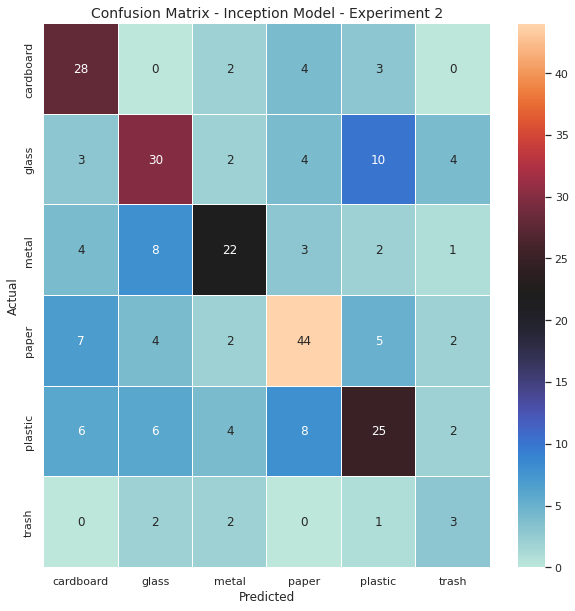

In [104]:
cm_i = pd.crosstab(y_test_enc.argmax(axis=1), 
                ipredictions, 
                rownames=['Actual'], 
                colnames=['Predicted'])

cm_i = cm_i.reindex([0,1,2,3,4,5], axis = 'columns', fill_value = 0)

fig, ax = plt.subplots(1, figsize=(10,10))

sns.heatmap(cm_i, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names,
            annot=True, ax=ax,
            linewidths=0.2,linecolor="white", cmap="icefire")

ax.set_ylim(6, 0)
ax.set_xlim(0, 6)
plt.title(f'Confusion Matrix - Inception Model - Experiment 2', fontsize=14)

plt.savefig(os.path.join(visualisation_path, 
                         'v002_confusion_matrix_IN01.png'), 
            dpi=300, bbox_inches='tight')

plt.show()
    

### Predicting on test images

Actual Category: glass
Predicted Category: glass


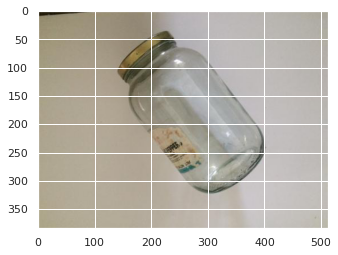

In [105]:
# Testing model performance on custom data

im1 = Image.open(data_path+"/glass/glass169.jpg")
plt.imshow(im1)
print("Actual Category: glass")

# Pre-processing the image

im1 = im1.convert('RGB')
im1 = im1.resize(IMAGE_DIMS)
im1 = np.expand_dims(im1, axis=0)
im1 = np.asarray(im1)

# Predicting using the model

pred1 = ifinal_model.predict([im1])[0]
pred1 = np.argmax(pred1)
print("Predicted Category:", target_names[pred1])

Actual Category: paper
Predicted Category: paper


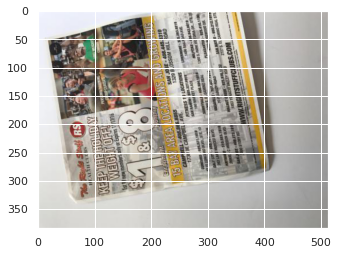

In [106]:
# Testing model performance on custom data

im2 = Image.open(data_path+"/paper/paper92.jpg")
plt.imshow(im2)
print("Actual Category: paper")

# Pre-processing the image
im2 = im2.convert('RGB')
im2 = im2.resize(IMAGE_DIMS)
im2 = np.expand_dims(im2, axis=0)
im2 = np.asarray(im2)

# Predicting using the model

pred2 = ifinal_model.predict([im2])[0]
pred2 = np.argmax(pred2)
print("Predicted Category:", target_names[pred2])

## Resnet model

In [52]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [53]:
# load the ResNet network
rbase_model = ResNet50(weights = "imagenet", 
                      include_top = False,
                      input_tensor = Input(IMAGE_SIZE))

94781440/94765736 [==============================] - 0s 0us/step


In [54]:
rbase_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [55]:
# construct the head of the model that will be placed on top of the
# the base model

rlast_layer = rbase_model.layers[-1]
print('last layer output shape: ', rlast_layer.output_shape)

rhead_model = rlast_layer.output
rhead_model = layers.Flatten()(rhead_model)
rhead_model = layers.Dense(6, activation = "softmax")(rhead_model) # 6 classes

last layer output shape:  (None, 7, 7, 2048)


In [56]:
# place the head model on top of the base model
rfinal_model = Model(inputs = rbase_model.input, outputs = rhead_model)

In [57]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in rbase_model.layers:
    layer.trainable = False

In [58]:
# compile our model
print("[INFO] compiling Resnet model...")

rfinal_model.compile(loss = "categorical_crossentropy", 
                    optimizer='adam',
                    metrics = ["accuracy"])

print("\n\n[INFO] Resnet model compilation complete!")

[INFO] compiling Resnet model...


[INFO] Resnet model compilation complete!


### Resnet Model Checkpoint

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint
rmodel_checkpoint_callback = ModelCheckpoint(filepath=os.path.join(save_model_path, 
                                                   "modelv002_RN01_{epoch:02d}.h5"), 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            monitor='val_loss',
                                            mode='min')

### Resnet Model Learning Rate Reduction

In [60]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
rlearning_rate_reduction_callback = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                     patience = 2, 
                                                     verbose = 1, 
                                                     factor = 0.5, 
                                                     min_lr = 1e-6)

### Resnet Model Early Stopping

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
rearly_stopping_callback = EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=5)

### Model training

In [62]:
# train the head of the network
print("[INFO] model training - epochs and summary...\n\n")

rfinal_model_history = rfinal_model.fit(aug.flow(X_train, y_train_enc, 
                                               batch_size = BATCH_SIZE),
                                      steps_per_epoch = len(X_train) // BATCH_SIZE,
                                      validation_data = (X_val, y_val_enc),
                                      validation_steps = len(X_val) // BATCH_SIZE,
                                      epochs = MODEL_EPOCHS,
                                      callbacks = [rmodel_checkpoint_callback, 
                                                   rearly_stopping_callback, 
                                                   rlearning_rate_reduction_callback])

print("\n\n[INFO] model training complete!\n\n")

[INFO] model training - epochs and summary...


Epoch 1/40
59/59 [==============================] - 33s 499ms/step - loss: 8.3228 - accuracy: 0.5926 - val_loss: 3.8031 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 2/40
59/59 [==============================] - 21s 361ms/step - loss: 3.9700 - accuracy: 0.7606 - val_loss: 4.4196 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 3/40
59/59 [==============================] - 23s 388ms/step - loss: 3.3081 - accuracy: 0.8084 - val_loss: 3.3426 - val_accuracy: 0.8232 - lr: 0.0010
Epoch 4/40
59/59 [==============================] - 22s 376ms/step - loss: 2.5594 - accuracy: 0.8272 - val_loss: 3.2656 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 5/40
59/59 [==============================] - 23s 382ms/step - loss: 2.7816 - accuracy: 0.8492 - val_loss: 4.8541 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 6/40
59/59 [==============================] - ETA: 0s - loss: 3.1967 - accuracy: 0.8336
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
59

In [63]:
rfinal_model_history_df = pd.DataFrame(rfinal_model_history.history)
rfinal_model_history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,8.322808,0.592593,3.803114,0.778364,0.001000
1,3.970010,0.760601,4.419562,0.781003,0.001000
2,3.308083,0.808374,3.342591,0.823219,0.001000
3,2.559366,0.827160,3.265609,0.828496,0.001000
4,2.781557,0.849168,4.854072,0.807388,0.001000
5,3.196673,0.833602,5.013040,0.812665,0.001000
6,2.116495,0.886205,4.276670,0.844327,0.000500
7,1.674234,0.901771,3.469437,0.836412,0.000500
8,1.636227,0.900698,3.086293,0.846966,0.000500
9,1.131289,0.923242,2.893072,0.878628,0.000500


In [64]:
rfinal_model_history_df.to_csv(os.path.join(save_model_path, 
                                            'rfinal_model_history_RN01.csv'),
                               index=False)

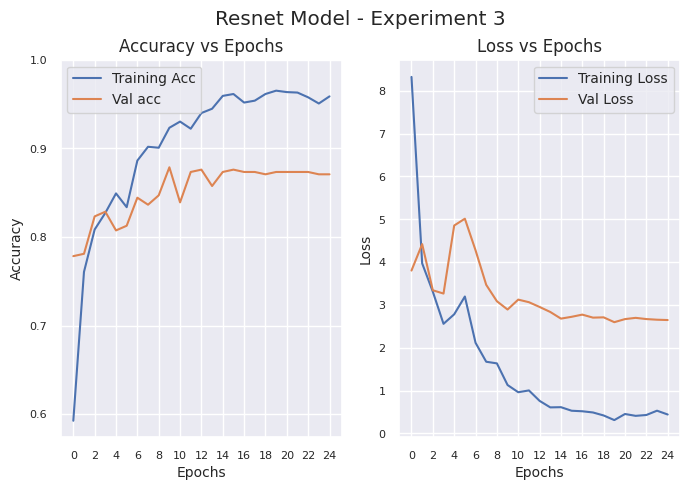

In [80]:
# Plots of Accuracy and Loss vs Epochs.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), dpi=100)


fig.suptitle("Resnet Model - Experiment 3", fontdict = {'size': 10, 'weight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(rfinal_model_history.history['accuracy'], label='Training Acc')
ax[0].plot(rfinal_model_history.history['val_accuracy'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 26, 2))
ax[0].yaxis.set_ticks(np.arange(0.6, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(rfinal_model_history.history['loss'], label='Training Loss')
ax[1].plot(rfinal_model_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 26, 2))
ax[1].yaxis.set_ticks(np.arange(0.0, 9.0, 1.0))

fig.savefig(os.path.join(visualisation_path, 
                         'v002_resnet_RN01.png'), 
            dpi=300, 
            bbox_inches='tight')

plt.show()

### Evaluating the model

In [66]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predictions = rfinal_model.predict(X_test, batch_size = BATCH_SIZE)
print("\n\n[INFO] evaluation complete!")

[INFO] evaluating network...


[INFO] evaluation complete!


In [67]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
print(classification_report(y_test_enc.argmax(axis=1), 
                            predictions, 
                            target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.97      0.94      0.96        36
       glass       1.00      0.78      0.88        55
       metal       0.80      0.93      0.86        42
       paper       0.88      1.00      0.94        58
     plastic       0.81      0.88      0.84        49
       trash       1.00      0.54      0.70        13

    accuracy                           0.89       253
   macro avg       0.91      0.85      0.86       253
weighted avg       0.90      0.89      0.88       253



In [70]:
# show classification report
print(classification_report(y_test_enc.argmax(axis=1), 
                            predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       1.00      0.78      0.88        55
           2       0.80      0.93      0.86        42
           3       0.88      1.00      0.94        58
           4       0.81      0.88      0.84        49
           5       1.00      0.54      0.70        13

    accuracy                           0.89       253
   macro avg       0.91      0.85      0.86       253
weighted avg       0.90      0.89      0.88       253



In [71]:
report = classification_report(y_test_enc.argmax(axis=1), 
                               predictions,
                               target_names=target_names,
                               output_dict = True)

df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
cardboard,0.971429,0.944444,0.957746,36.000000
glass,1.000000,0.781818,0.877551,55.000000
metal,0.795918,0.928571,0.857143,42.000000
paper,0.878788,1.000000,0.935484,58.000000
plastic,0.811321,0.877551,0.843137,49.000000
trash,1.000000,0.538462,0.700000,13.000000
accuracy,0.885375,0.885375,0.885375,0.885375
macro avg,0.909576,0.845141,0.861844,253.000000
weighted avg,0.897725,0.885375,0.883067,253.000000


In [72]:
# saving the classification report to a csv file
df_report.to_csv(os.path.join(save_model_path, 
                         'v002_resnet_RN01.csv'),  
                  index=False)

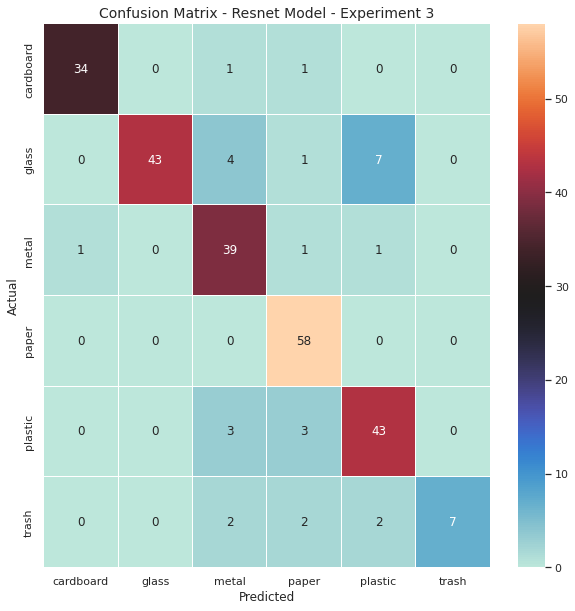

In [73]:
cm = pd.crosstab(y_test_enc.argmax(axis=1), 
                predictions, 
                rownames=['Actual'], 
                colnames=['Predicted'])

fig, ax = plt.subplots(1, figsize=(10,10))

sns.heatmap(cm, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names,
            annot=True, ax=ax,
            linewidths=0.2,linecolor="white", cmap="icefire")

ax.set_ylim(6, 0)
ax.set_xlim(0, 6)
plt.title(f'Confusion Matrix - Resnet Model - Experiment 3', fontsize=14)

plt.savefig(os.path.join(visualisation_path, 
                         'v002_confusion_matrix_RN01.png'), 
            dpi=300, bbox_inches='tight')

plt.show()
    

### Predicting on test images

Actual Category: glass
Predicted Category: glass


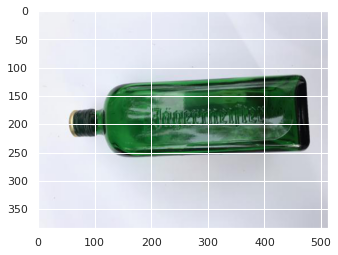

In [189]:
# Testing model performance on custom data

im1 = Image.open(data_path+"/glass/glass152.jpg")
plt.imshow(im1)
print("Actual Category: glass")

# Pre-processing the image

im1 = im1.convert('RGB')
im1 = im1.resize(IMAGE_DIMS)
im1 = np.expand_dims(im1, axis=0)
im1 = np.asarray(im1)

# Predicting using the model

pred1_r = rfinal_model.predict([im1])[0]
pred1_r = np.argmax(pred1_r)
print("Predicted Category:", target_names[pred1_r])

Actual Category: cardboard
Predicted Category: cardboard


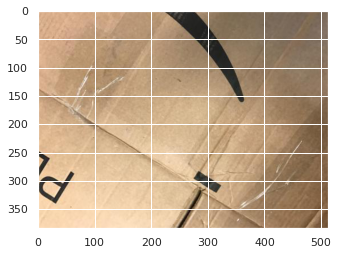

In [190]:
# Testing model performance on custom data

im2 = Image.open(data_path+"/cardboard/cardboard40.jpg")
plt.imshow(im2)
print("Actual Category: cardboard")

# Pre-processing the image
im2 = im2.convert('RGB')
im2 = im2.resize(IMAGE_DIMS)
im2 = np.expand_dims(im2, axis=0)
im2 = np.asarray(im2)

# Predicting using the model

pred2_r = rfinal_model.predict([im2])
pred2_r = np.argmax(pred2_r)
print("Predicted Category:", target_names[pred2_r])